# Emotion Prediction

### Download the data

In [ ]:
from google.colab import files
files.upload() # upload kaggle.json file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d msambare/fer2013
!mkdir data
!mv /content/fer2013.zip data/fer2013.zip
!unzip /content/data/fer2013.zip -d data/

### Import relevent libraries

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset, DataLoader, Dataset
import matplotlib.pyplot as plt
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loader and Dataset 

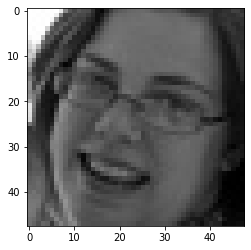

In [ ]:
img = cv2.imread('/content/data/train/happy/Training_10019449.jpg')
plt.imshow(img)

In [ ]:
trn_df = pd.DataFrame(columns=['file', 'label'])

folders = glob.glob('/content/data/train/*')
for fol in folders:
    for fil in glob.glob(fol+'/*'):
        df_tmp = pd.DataFrame([(fil, fil.split('/')[4])], columns=['file', 'label'])
        trn_df = trn_df.append(df_tmp)


In [ ]:
trn_df

,file,label
0,/content/data/train/neutral/Training_16301547.jpg,neutral
0,/content/data/train/neutral/Training_78375365.jpg,neutral
0,/content/data/train/neutral/Training_57111186.jpg,neutral
0,/content/data/train/neutral/Training_21066615.jpg,neutral
0,/content/data/train/neutral/Training_26611783.jpg,neutral
...,...,...
0,/content/data/train/sad/Training_98534980.jpg,sad
0,/content/data/train/sad/Training_7360259.jpg,sad
0,/content/data/train/sad/Training_36386615.jpg,sad
0,/content/data/train/sad/Training_51565493.jpg,sad


In [ ]:
TRAIN_DATA_PATH = "/content/data/train"
dataset = datasets.ImageFolder(TRAIN_DATA_PATH, transform=transforms.ToTensor())

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, df, transform=None, IMAGE_SIZE=48):
        self.df = df
        self.label_dict = self.labelize(df)
        self.IMAGE_SIZE = IMAGE_SIZE
    
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        f = self.df.iloc[idx].squeeze()
        file = f.file
        label = self.label_dict[f.label]

        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img, label

    def preprocess_image(self, img):
        im = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE))
        im = torch.tensor(im)
        im = im/255.
        return im[None]

    def collate_fn(self, batch):
        '''
        preprocess images, emotion labels
        '''
        imgs, labels = [], []
        for im, label in batch:

            im = self.preprocess_image(im)
            imgs.append(im)
            
            labels.append(float(label))
        
        labels = torch.tensor(labels).to(device).float()
        imgs = torch.cat(imgs).to(device)
        imgs = imgs.view(-1,1,48,48)
        
        return imgs, labels


    def labelize(self, df):
        label_dict = {}
        for i,name in enumerate(df.label.unique()):
            label_dict[name] = i
        return label_dict
  
trn = EmotionDataset(trn_df)


In [ ]:
train_loader = DataLoader(trn, batch_size=32, shuffle=True, \
                          drop_last=True, collate_fn=trn.collate_fn)

In [ ]:
img, lab = next(iter(train_loader))
print(img.shape, lab.shape)

torch.Size([32, 1, 48, 48]) torch.Size([32])


### Build Model

In [ ]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()

        self.core_layer_1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.core_layer_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            
        )

        self.dense_layer = nn.Sequential(
            nn.Flatten(),

            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.BatchNorm1d(2048),
            nn.Dropout(0.2),

            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.2),

            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),

            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),

            nn.Linear(32, 7),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.core_layer_1(x)
        x = self.core_layer_2(x)
        x = self.dense_layer(x)
        return x

model = EmotionClassifier()

x = torch.zeros(1, 48, 48)
print(x.shape)
summary(model.to(device), x.to(device).shape)

torch.Size([1, 48, 48])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 46, 46]             640
              ReLU-2           [-1, 64, 46, 46]               0
       BatchNorm2d-3           [-1, 64, 46, 46]             128
            Conv2d-4           [-1, 64, 44, 44]          36,928
              ReLU-5           [-1, 64, 44, 44]               0
       BatchNorm2d-6           [-1, 64, 44, 44]             128
            Conv2d-7           [-1, 32, 42, 42]          18,464
              ReLU-8           [-1, 32, 42, 42]               0
       BatchNorm2d-9           [-1, 32, 42, 42]              64
        MaxPool2d-10           [-1, 32, 21, 21]               0
          Dropout-11           [-1, 32, 21, 21]               0
           Conv2d-12           [-1, 64, 19, 19]          18,496
             ReLU-13           [-1, 64, 19, 19]               0
      BatchNorm

In [ ]:
def get_model():
    model = EmotionClassifier()

    criterion = nn.CrossEntropyLoss()

    loss_fn = criterion

    optimizer = torch.optim.Adam(model.parameters(),lr= 1e-4)
    return model.to(device), loss_fn, optimizer

In [ ]:
model, criterion, optimizer = get_model()

In [ ]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    imgs, labels = data

    imgs = imgs.to(device)
    labels = labels.type(torch.LongTensor)
    labels = labels.to(device)

    optimizer.zero_grad()
    pred_label = model(imgs)

    # for future use
    criterion = criteria(pred_label, labels)

    criterion.backward()
    optimizer.step()

    return criterion

def validate_batch(data, model, criteria):
    model.eval()

    imgs, labels = data

    imgs = imgs.to(device)
    labels = labels.type(torch.LongTensor)
    labels = labels.to(device)

    with torch.no_grad():
        pred_label = model(imgs)

    criterion = criteria(pred_label, labels.type(torch.LongTensor))
    
    return criterion

In [ ]:
import time
from tqdm import tqdm
from tqdm import trange 

model, criteria, optimizer = get_model()

train_losses = []

val_losses = []
n_epochs = 100
best_test_loss = 1000
start = time.time()

for epoch in trange(n_epochs, desc="Epoch : "):

    epoch_train_loss, epoch_test_loss = 0, 0
    ctr = 0
    _n = len(train_loader)

    for ix, data in enumerate(tqdm(train_loader, position=0, leave=True)):
        loss = train_batch(data, model, optimizer, criteria)
        epoch_train_loss += loss.item()
    
    # for ix, data in enumerate(tqdm(test_loader, position=0, leave=True)):
    #     loss, gender_acc, age_mae = validate_batch(data, model, criteria)
    #     epoch_test_loss += loss.item()
    #     val_age_mae += age_mae
    #     val_gender_acc += gender_acc
    #     ctr += len(data[0])
    
    epoch_train_loss /= len(train_loader)
    # epoch_test_loss /= len(test_loader)


    elapsed = time.time()-start
    best_test_loss = min(best_test_loss, epoch_test_loss)
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(\
    epoch+1, n_epochs, time.time()-start, \
    (n_epochs-epoch)*(elapsed/(epoch+1))))
    info = f'''Epoch: {epoch+1:03d}\
    \tTrain Loss: {epoch_train_loss:.3f}
    \tTest:{epoch_test_loss:.3f}
    \tBest Test Loss: {best_test_loss:.4f}'''

    # info += f'\nGender Accuracy:\
    # {val_gender_acc*100:.2f}%\tAge MAE: \
    # {val_age_mae:.2f}\n'

    print(info)



Epoch :   1%|          | 1/100 [00:47<1:17:33, 47.01s/it]

1/100 (47.02s - 4701.60s remaining)
Epoch: 001    	Train Loss: 1.835
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :   2%|▏         | 2/100 [01:31<1:14:50, 45.82s/it]

2/100 (92.00s - 4554.12s remaining)
Epoch: 002    	Train Loss: 1.646
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :   3%|▎         | 3/100 [02:16<1:13:20, 45.37s/it]

3/100 (136.84s - 4470.09s remaining)
Epoch: 003    	Train Loss: 1.545
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :   4%|▍         | 4/100 [03:01<1:12:20, 45.21s/it]

4/100 (181.81s - 4408.85s remaining)
Epoch: 004    	Train Loss: 1.458
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :   5%|▌         | 5/100 [03:46<1:11:17, 45.03s/it]

5/100 (226.51s - 4348.99s remaining)
Epoch: 005    	Train Loss: 1.396
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :   6%|▌         | 6/100 [04:31<1:10:25, 44.95s/it]

6/100 (271.30s - 4295.57s remaining)
Epoch: 006    	Train Loss: 1.337
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :   7%|▋         | 7/100 [05:16<1:09:35, 44.90s/it]

7/100 (316.10s - 4244.72s remaining)
Epoch: 007    	Train Loss: 1.284
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :   8%|▊         | 8/100 [06:00<1:08:42, 44.81s/it]

8/100 (360.73s - 4193.44s remaining)
Epoch: 008    	Train Loss: 1.246
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :   9%|▉         | 9/100 [06:45<1:07:53, 44.76s/it]

9/100 (405.37s - 4143.80s remaining)
Epoch: 009    	Train Loss: 1.196
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  10%|█         | 10/100 [07:30<1:07:14, 44.82s/it]

10/100 (450.33s - 4098.05s remaining)
Epoch: 010    	Train Loss: 1.146
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  11%|█         | 11/100 [08:15<1:06:42, 44.98s/it]

11/100 (495.66s - 4055.38s remaining)
Epoch: 011    	Train Loss: 1.119
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  12%|█▏        | 12/100 [09:00<1:06:00, 45.00s/it]

12/100 (540.72s - 4010.34s remaining)
Epoch: 012    	Train Loss: 1.078
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  13%|█▎        | 13/100 [09:45<1:05:12, 44.97s/it]

13/100 (585.62s - 3964.20s remaining)
Epoch: 013    	Train Loss: 1.038
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  14%|█▍        | 14/100 [10:30<1:04:22, 44.92s/it]

14/100 (630.41s - 3917.54s remaining)
Epoch: 014    	Train Loss: 1.009
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  15%|█▌        | 15/100 [11:15<1:03:34, 44.88s/it]

15/100 (675.19s - 3871.09s remaining)
Epoch: 015    	Train Loss: 0.975
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  16%|█▌        | 16/100 [11:59<1:02:44, 44.82s/it]

16/100 (719.87s - 3824.33s remaining)
Epoch: 016    	Train Loss: 0.934
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  17%|█▋        | 17/100 [12:44<1:01:52, 44.73s/it]

17/100 (764.41s - 3777.10s remaining)
Epoch: 017    	Train Loss: 0.901
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  18%|█▊        | 18/100 [13:29<1:01:08, 44.74s/it]

18/100 (809.18s - 3731.22s remaining)
Epoch: 018    	Train Loss: 0.874
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  19%|█▉        | 19/100 [14:14<1:00:27, 44.78s/it]

19/100 (854.04s - 3685.87s remaining)
Epoch: 019    	Train Loss: 0.825
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  20%|██        | 20/100 [14:59<59:54, 44.94s/it]  

20/100 (899.34s - 3642.33s remaining)
Epoch: 020    	Train Loss: 0.802
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  21%|██        | 21/100 [15:44<59:07, 44.90s/it]

21/100 (944.17s - 3596.83s remaining)
Epoch: 021    	Train Loss: 0.769
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  22%|██▏       | 22/100 [16:28<58:19, 44.86s/it]

22/100 (988.94s - 3551.20s remaining)
Epoch: 022    	Train Loss: 0.741
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  23%|██▎       | 23/100 [17:13<57:32, 44.84s/it]

23/100 (1033.72s - 3505.66s remaining)
Epoch: 023    	Train Loss: 0.718
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  24%|██▍       | 24/100 [17:58<56:52, 44.91s/it]

24/100 (1078.79s - 3461.11s remaining)
Epoch: 024    	Train Loss: 0.680
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  25%|██▌       | 25/100 [18:43<56:03, 44.84s/it]

25/100 (1123.49s - 3415.40s remaining)
Epoch: 025    	Train Loss: 0.661
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  26%|██▌       | 26/100 [19:28<55:14, 44.80s/it]

26/100 (1168.17s - 3369.72s remaining)
Epoch: 026    	Train Loss: 0.632
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  27%|██▋       | 27/100 [20:13<54:32, 44.83s/it]

27/100 (1213.07s - 3324.70s remaining)
Epoch: 027    	Train Loss: 0.616
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  28%|██▊       | 28/100 [20:57<53:47, 44.83s/it]

28/100 (1257.89s - 3279.51s remaining)
Epoch: 028    	Train Loss: 0.586
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  29%|██▉       | 29/100 [21:43<53:14, 44.99s/it]

29/100 (1303.27s - 3235.71s remaining)
Epoch: 029    	Train Loss: 0.573
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  30%|███       | 30/100 [22:28<52:26, 44.96s/it]

30/100 (1348.15s - 3190.61s remaining)
Epoch: 030    	Train Loss: 0.551
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  31%|███       | 31/100 [23:12<51:39, 44.92s/it]

31/100 (1392.98s - 3145.45s remaining)
Epoch: 031    	Train Loss: 0.521
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  32%|███▏      | 32/100 [23:57<50:52, 44.88s/it]

32/100 (1437.78s - 3100.21s remaining)
Epoch: 032    	Train Loss: 0.511
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  33%|███▎      | 33/100 [24:42<50:04, 44.85s/it]

33/100 (1482.54s - 3054.93s remaining)
Epoch: 033    	Train Loss: 0.479
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  34%|███▍      | 34/100 [25:27<49:23, 44.91s/it]

34/100 (1527.59s - 3010.26s remaining)
Epoch: 034    	Train Loss: 0.470
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  35%|███▌      | 35/100 [26:12<48:37, 44.88s/it]

35/100 (1572.42s - 2965.13s remaining)
Epoch: 035    	Train Loss: 0.475
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  36%|███▌      | 36/100 [26:57<47:50, 44.85s/it]

36/100 (1617.20s - 2919.94s remaining)
Epoch: 036    	Train Loss: 0.441
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  37%|███▋      | 37/100 [27:42<47:12, 44.96s/it]

37/100 (1662.42s - 2875.53s remaining)
Epoch: 037    	Train Loss: 0.434
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  38%|███▊      | 38/100 [28:27<46:29, 44.99s/it]

38/100 (1707.48s - 2830.83s remaining)
Epoch: 038    	Train Loss: 0.415
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  39%|███▉      | 39/100 [29:12<45:44, 45.00s/it]

39/100 (1752.49s - 2786.01s remaining)
Epoch: 039    	Train Loss: 0.411
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  40%|████      | 40/100 [29:57<44:58, 44.97s/it]

40/100 (1797.40s - 2741.03s remaining)
Epoch: 040    	Train Loss: 0.395
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  41%|████      | 41/100 [30:42<44:16, 45.02s/it]

41/100 (1842.54s - 2696.40s remaining)
Epoch: 041    	Train Loss: 0.392
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  42%|████▏     | 42/100 [31:27<43:28, 44.97s/it]

42/100 (1887.39s - 2651.33s remaining)
Epoch: 042    	Train Loss: 0.384
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  43%|████▎     | 43/100 [32:12<42:42, 44.96s/it]

43/100 (1932.34s - 2606.41s remaining)
Epoch: 043    	Train Loss: 0.358
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  44%|████▍     | 44/100 [32:57<42:04, 45.08s/it]

44/100 (1977.67s - 2561.99s remaining)
Epoch: 044    	Train Loss: 0.351
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  45%|████▌     | 45/100 [33:42<41:22, 45.13s/it]

45/100 (2022.92s - 2517.42s remaining)
Epoch: 045    	Train Loss: 0.338
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  46%|████▌     | 46/100 [34:27<40:32, 45.04s/it]

46/100 (2067.77s - 2472.33s remaining)
Epoch: 046    	Train Loss: 0.333
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  47%|████▋     | 47/100 [35:12<39:47, 45.04s/it]

47/100 (2112.80s - 2427.47s remaining)
Epoch: 047    	Train Loss: 0.327
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  48%|████▊     | 48/100 [35:57<38:59, 44.98s/it]

48/100 (2157.64s - 2382.40s remaining)
Epoch: 048    	Train Loss: 0.322
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  49%|████▉     | 49/100 [36:42<38:12, 44.94s/it]

49/100 (2202.50s - 2337.34s remaining)
Epoch: 049    	Train Loss: 0.312
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  50%|█████     | 50/100 [37:27<37:26, 44.94s/it]

50/100 (2247.42s - 2292.37s remaining)
Epoch: 050    	Train Loss: 0.311
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  51%|█████     | 51/100 [38:12<36:48, 45.07s/it]

51/100 (2292.82s - 2247.86s remaining)
Epoch: 051    	Train Loss: 0.304
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  52%|█████▏    | 52/100 [38:57<35:58, 44.96s/it]

52/100 (2337.52s - 2202.66s remaining)
Epoch: 052    	Train Loss: 0.294
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  53%|█████▎    | 53/100 [39:42<35:08, 44.87s/it]

53/100 (2382.16s - 2157.43s remaining)
Epoch: 053    	Train Loss: 0.287
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  54%|█████▍    | 54/100 [40:26<34:21, 44.82s/it]

54/100 (2426.86s - 2112.27s remaining)
Epoch: 054    	Train Loss: 0.281
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  55%|█████▌    | 55/100 [41:11<33:32, 44.73s/it]

55/100 (2471.40s - 2066.99s remaining)
Epoch: 055    	Train Loss: 0.272
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  56%|█████▌    | 56/100 [41:55<32:46, 44.69s/it]

56/100 (2516.00s - 2021.78s remaining)
Epoch: 056    	Train Loss: 0.261
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  57%|█████▋    | 57/100 [42:40<32:02, 44.70s/it]

57/100 (2560.73s - 1976.70s remaining)
Epoch: 057    	Train Loss: 0.269
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  58%|█████▊    | 58/100 [43:25<31:17, 44.70s/it]

58/100 (2605.41s - 1931.60s remaining)
Epoch: 058    	Train Loss: 0.261
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  59%|█████▉    | 59/100 [44:09<30:30, 44.63s/it]

59/100 (2649.90s - 1886.37s remaining)
Epoch: 059    	Train Loss: 0.254
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  60%|██████    | 60/100 [44:54<29:45, 44.63s/it]

60/100 (2694.51s - 1841.25s remaining)
Epoch: 060    	Train Loss: 0.252
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  61%|██████    | 61/100 [45:39<28:59, 44.61s/it]

61/100 (2739.09s - 1796.12s remaining)
Epoch: 061    	Train Loss: 0.245
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  62%|██████▏   | 62/100 [46:23<28:15, 44.62s/it]

62/100 (2783.72s - 1751.05s remaining)
Epoch: 062    	Train Loss: 0.242
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  63%|██████▎   | 63/100 [47:08<27:31, 44.65s/it]

63/100 (2828.43s - 1706.04s remaining)
Epoch: 063    	Train Loss: 0.247
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  64%|██████▍   | 64/100 [47:53<26:52, 44.78s/it]

64/100 (2873.53s - 1661.26s remaining)
Epoch: 064    	Train Loss: 0.230
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  65%|██████▌   | 65/100 [48:38<26:07, 44.80s/it]

65/100 (2918.36s - 1616.32s remaining)
Epoch: 065    	Train Loss: 0.232
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  66%|██████▌   | 66/100 [49:22<25:20, 44.71s/it]

66/100 (2962.88s - 1571.23s remaining)
Epoch: 066    	Train Loss: 0.225
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  67%|██████▋   | 67/100 [50:07<24:34, 44.67s/it]

67/100 (3007.46s - 1526.17s remaining)
Epoch: 067    	Train Loss: 0.225
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  68%|██████▊   | 68/100 [50:52<23:52, 44.78s/it]

68/100 (3052.48s - 1481.35s remaining)
Epoch: 068    	Train Loss: 0.217
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  69%|██████▉   | 69/100 [51:37<23:08, 44.80s/it]

69/100 (3097.34s - 1436.45s remaining)
Epoch: 069    	Train Loss: 0.223
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  70%|███████   | 70/100 [52:22<22:26, 44.88s/it]

70/100 (3142.38s - 1391.63s remaining)
Epoch: 070    	Train Loss: 0.223
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  71%|███████   | 71/100 [53:07<21:41, 44.88s/it]

71/100 (3187.26s - 1346.73s remaining)
Epoch: 071    	Train Loss: 0.207
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  72%|███████▏  | 72/100 [53:51<20:55, 44.83s/it]

72/100 (3231.99s - 1301.77s remaining)
Epoch: 072    	Train Loss: 0.216
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  73%|███████▎  | 73/100 [54:38<20:22, 45.27s/it]

73/100 (3278.29s - 1257.43s remaining)
Epoch: 073    	Train Loss: 0.207
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  74%|███████▍  | 74/100 [55:22<19:32, 45.10s/it]

74/100 (3322.99s - 1212.44s remaining)
Epoch: 074    	Train Loss: 0.201
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  75%|███████▌  | 75/100 [56:08<18:48, 45.15s/it]

75/100 (3368.25s - 1167.66s remaining)
Epoch: 075    	Train Loss: 0.205
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  76%|███████▌  | 76/100 [56:52<17:59, 44.96s/it]

76/100 (3412.77s - 1122.62s remaining)
Epoch: 076    	Train Loss: 0.203
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  77%|███████▋  | 77/100 [57:37<17:11, 44.86s/it]

77/100 (3457.41s - 1077.63s remaining)
Epoch: 077    	Train Loss: 0.194
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  78%|███████▊  | 78/100 [58:22<16:25, 44.80s/it]

78/100 (3502.05s - 1032.65s remaining)
Epoch: 078    	Train Loss: 0.199
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  79%|███████▉  | 79/100 [59:06<15:39, 44.73s/it]

79/100 (3546.62s - 987.67s remaining)
Epoch: 079    	Train Loss: 0.195
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  80%|████████  | 80/100 [59:51<14:54, 44.70s/it]

80/100 (3591.25s - 942.70s remaining)
Epoch: 080    	Train Loss: 0.187
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  81%|████████  | 81/100 [1:00:36<14:13, 44.90s/it]

81/100 (3636.62s - 897.93s remaining)
Epoch: 081    	Train Loss: 0.183
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  82%|████████▏ | 82/100 [1:01:21<13:27, 44.84s/it]

82/100 (3681.31s - 852.99s remaining)
Epoch: 082    	Train Loss: 0.177
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  83%|████████▎ | 83/100 [1:02:05<12:40, 44.74s/it]

83/100 (3725.83s - 808.01s remaining)
Epoch: 083    	Train Loss: 0.189
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  84%|████████▍ | 84/100 [1:02:50<11:56, 44.80s/it]

84/100 (3770.75s - 763.13s remaining)
Epoch: 084    	Train Loss: 0.181
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  85%|████████▌ | 85/100 [1:03:36<11:14, 44.99s/it]

85/100 (3816.18s - 718.34s remaining)
Epoch: 085    	Train Loss: 0.180
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  86%|████████▌ | 86/100 [1:04:21<10:30, 45.03s/it]

86/100 (3861.33s - 673.49s remaining)
Epoch: 086    	Train Loss: 0.184
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  87%|████████▋ | 87/100 [1:05:06<09:46, 45.08s/it]

87/100 (3906.51s - 628.63s remaining)
Epoch: 087    	Train Loss: 0.172
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  88%|████████▊ | 88/100 [1:05:52<09:02, 45.21s/it]

88/100 (3952.03s - 583.82s remaining)
Epoch: 088    	Train Loss: 0.182
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  89%|████████▉ | 89/100 [1:06:37<08:17, 45.21s/it]

89/100 (3997.24s - 538.95s remaining)
Epoch: 089    	Train Loss: 0.173
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  90%|█████████ | 90/100 [1:07:22<07:32, 45.27s/it]

90/100 (4042.65s - 494.10s remaining)
Epoch: 090    	Train Loss: 0.172
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  91%|█████████ | 91/100 [1:08:07<06:47, 45.27s/it]

91/100 (4087.91s - 449.22s remaining)
Epoch: 091    	Train Loss: 0.165
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  92%|█████████▏| 92/100 [1:08:53<06:01, 45.23s/it]

92/100 (4133.04s - 404.32s remaining)
Epoch: 092    	Train Loss: 0.164
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  93%|█████████▎| 93/100 [1:09:38<05:16, 45.20s/it]

93/100 (4178.19s - 359.41s remaining)
Epoch: 093    	Train Loss: 0.158
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  94%|█████████▍| 94/100 [1:10:23<04:30, 45.13s/it]

94/100 (4223.14s - 314.49s remaining)
Epoch: 094    	Train Loss: 0.167
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  95%|█████████▌| 95/100 [1:11:08<03:45, 45.11s/it]

95/100 (4268.22s - 269.57s remaining)
Epoch: 095    	Train Loss: 0.162
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  96%|█████████▌| 96/100 [1:11:53<03:00, 45.16s/it]

96/100 (4313.48s - 224.66s remaining)
Epoch: 096    	Train Loss: 0.162
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  97%|█████████▋| 97/100 [1:12:38<02:15, 45.20s/it]

97/100 (4358.78s - 179.74s remaining)
Epoch: 097    	Train Loss: 0.160
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  98%|█████████▊| 98/100 [1:13:23<01:30, 45.10s/it]

98/100 (4403.65s - 134.81s remaining)
Epoch: 098    	Train Loss: 0.151
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch :  99%|█████████▉| 99/100 [1:14:08<00:45, 45.10s/it]

99/100 (4448.75s - 89.87s remaining)
Epoch: 099    	Train Loss: 0.150
    	Test:0.000
    	Best Test Loss: 0.0000


Epoch : 100%|██████████| 100/100 [1:14:53<00:00, 44.94s/it]

100/100 (4493.77s - 44.94s remaining)
Epoch: 100    	Train Loss: 0.162
    	Test:0.000
    	Best Test Loss: 0.0000


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Emotion_Prediction/model.pth')

In [ ]:
epoch_train_loss

0.1623768356837407

In [ ]:
# model()
for i in trn:
  model.eval()
  imgs = torch.Tensor(i[0]).to(device)
  imgs = imgs.view(-1,1,48,48)
  print(model(imgs))
  break

tensor([[6.3574, 0.0000, 0.0000, 0.0000, 0.0000, 5.8535, 0.9545]],
       device='cuda:0', grad_fn=<ReluBackward0>)


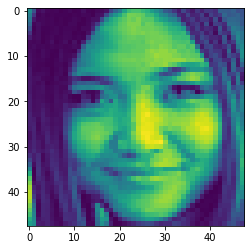

In [ ]:
plt.imshow(i[0])

In [ ]:
trn.label_dict

{'angry': 1,
 'disgust': 3,
 'fear': 4,
 'happy': 5,
 'neutral': 0,
 'sad': 6,
 'surprise': 2}